In [34]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from cfollmer.evaluation_utils import ECE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
a9a_train = pd.read_csv("a9a.csv", header=None)
a9a_test = pd.read_csv("a9a_t.csv", header=None)

In [38]:
X_train = a9a_train.values[:, :-1]
X_test = a9a_test.values[:, :-1]

y_train = a9a_train.values[:, -1]
y_test = a9a_test.values[:, -1]

X_train = torch.tensor(X_train, device=device, dtype=torch.float)
X_test = torch.tensor(X_test, device=device, dtype=torch.float)

y_train = torch.tensor(y_train, device=device, dtype=torch.float)
y_test = torch.tensor(y_test, device=device, dtype=torch.float)

X_train = F.pad(X_train, (0, 1), value=1.0)
X_test = F.pad(X_test, (0, 1), value=1.0)

N, dim = X_train.shape

In [5]:
def log_prior(beta):
    return -torch.sum(torch.abs(beta))

def log_likelihood(x, y, beta):
    return -F.binary_cross_entropy_with_logits(x @ beta, y, reduction="sum")

def log_posterior(x, y, params):
    return log_prior(params) + (N / x.shape[0]) * log_likelihood(x, y, params)

def log_posterior_batch(x, y, beta_batch):
    func = lambda beta: log_posterior(x, y, beta)
    func = torch.vmap(func)
    return func(beta_batch)

In [6]:
class SDE(torch.nn.Module):
    
    def __init__(self, gamma, input_dim, width=300):
        super().__init__()
        activation = torch.nn.Softplus
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(input_dim + 1, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, width), torch.nn.BatchNorm1d(width, affine=False), activation(),
            torch.nn.Linear(width, input_dim)
        )
        
        self.nn[-1].weight.data.fill_(0)
        self.nn[-1].bias.data.fill_(0)
        
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
        self.gamma = gamma
    
    def f(self, t, params_batch):
        t_ = t * torch.ones((params_batch.shape[0], 1), device=params_batch.device)
        return self.nn(torch.cat((t_, params_batch), dim=-1))
    
    def g(self, t, params_batch):
        return torch.sqrt(self.gamma * torch.ones_like(params_batch))

In [7]:
def loss(sde, x, y, dt=0.05):
    n_steps = int(1.0 / dt)
    ts = torch.linspace(0, 1, n_steps, device=device)
    
    param_init = torch.zeros((param_batch_size, dim), device=device)
    param_trajectory = torchsde.sdeint(sde, param_init, ts, method="euler", dt=dt)
    param_T = param_trajectory[-1]
    
    fs = torch.vmap(sde.f)(ts, param_trajectory)
    
    energy_cost = torch.sum(fs**2, dim=[0, 2]) * dt  / (2 * gamma)
    terminal_cost = - torch.sum(param_T**2, dim=1) / (2 * gamma) - log_posterior_batch(x, y, param_T)
    
    return torch.mean(energy_cost + terminal_cost) / N

In [15]:
gamma = 0.2**2
sde = SDE(gamma, dim).to(device)

optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)

n_epochs = 300
data_batch_size = N
param_batch_size = 32

In [16]:
losses = []

for _ in range(n_epochs):
    epoch_losses = []
    
    perm = torch.randperm(N)
    X_train = X_train[perm]
    y_train = y_train[perm]
    
    for i in tqdm(range(0, N, data_batch_size)):
        x = X_train[i:min(i + data_batch_size, N)]
        y = y_train[i:min(i + data_batch_size, N)]
        
        optimizer.zero_grad()
        l = loss(sde, x, y, dt=0.05)
        l.backward()
        epoch_losses.append(l.detach().cpu().numpy())
        optimizer.step()
        
    losses.append(epoch_losses)

  0%|                                                                          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_575185/1374780470.py:9: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  fs = torch.vmap(sde.f)(ts, param_trajectory)
/tmp/ipykernel_575185/2224098311.py:12: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)
100%|██████████████████████████████████████████

100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.23it/s]


100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.68it/s]


100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.78it/s]


In [17]:
losses = np.array(losses)

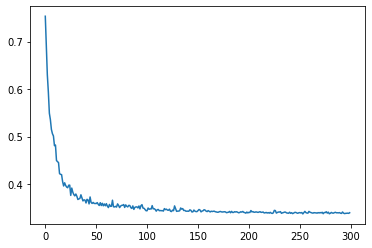

In [18]:
plt.plot(losses.flatten())

In [61]:
with torch.no_grad():
    dt = 0.001
    n_steps = int(1.0 / dt)
    ts = torch.linspace(0, 1, n_steps, device=device)
    
    beta_init = torch.zeros((50, dim), device=device)
    beta_trajectory = torchsde.sdeint(sde, beta_init, ts, method="euler", dt=dt)
    beta_samples = beta_trajectory[-1]

In [62]:
with torch.no_grad():
    predict_func = lambda beta : X_test @ beta
    predict_func = torch.vmap(predict_func)
    
    logps = log_posterior_batch(X_test, y_test, beta_samples)
    logps = torch.mean(logps)
    out = predict_func(beta_samples)
    out = torch.sigmoid(out)
    probs = torch.mean(out, dim=0)
    preds = torch.round(probs)

/tmp/ipykernel_575185/3358297183.py:3: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  predict_func = torch.vmap(predict_func)
/tmp/ipykernel_575185/2224098311.py:12: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)


In [63]:
logps / N

tensor(-0.3412, device='cuda:0')

In [64]:
(X_test.shape[0] - torch.sum(torch.abs(preds - y_test))) / X_test.shape[0]

tensor(0.8483, device='cuda:0')

In [65]:
conf = torch.max(1 - probs, probs)
ECE(conf.cpu().numpy(), preds.cpu().numpy(), y_test.cpu().numpy())

0.007383278382585209

In [47]:
@torch.enable_grad()
def gradient(x, y, beta):
    beta_ = beta.clone().requires_grad_(True)
    loss = log_posterior(x, y, beta_)
    grad, = torch.autograd.grad(loss, beta_)
    return loss.detach().cpu().numpy(), grad

In [48]:
def step_size(n):
    return 0.001 / (1 + n)**0.5

In [52]:
beta = torch.zeros(dim).float().to(device)
n_epochs = 300

In [53]:
step = 0

losses = []
accuracies = []
logps = []

for _ in range(n_epochs):
    perm = torch.randperm(N)
    X_train = X_train[perm]
    y_train = y_train[perm]
    
    for i in tqdm(range(0, N, data_batch_size)):
        x = X_train[i:min(i + data_batch_size, N)]
        y = y_train[i:min(i + data_batch_size, N)]
        
        eps = step_size(step)
        loss, grad = gradient(x, y, beta)
        beta = beta + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(beta)
        step += 1
        losses.append(epoch_losses)
        
        with torch.no_grad():
            test_pred = torch.round(torch.sigmoid(X_test @ beta))
            test_acc = torch.mean(1 - torch.abs(y_test - test_pred))
            logp = log_posterior(X_test, y_test, beta) / X_test.shape[0]
        
            accuracies.append(test_acc.cpu().numpy())
            logps.append(logp.cpu().numpy())

100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1486.81it/s]


100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1467.05it/s]


100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1440.35it/s]


100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1470.65it/s]


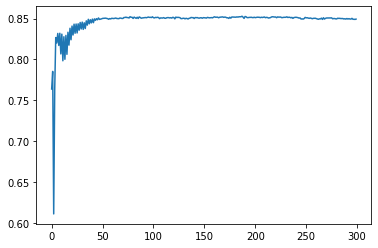

In [54]:
plt.plot(accuracies)

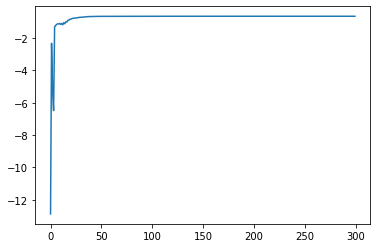

In [55]:
plt.plot(logps)

In [66]:
beta_samples = []

for _ in range(50):
    perm = torch.randperm(N)
    X_train = X_train[perm]
    y_train = y_train[perm]
    
    for i in tqdm(range(0, N, data_batch_size)):
        x = X_train[i:min(i + data_batch_size, N)]
        y = y_train[i:min(i + data_batch_size, N)]
        
        eps = step_size(step)
        loss, grad = gradient(x, y, beta)
        beta = beta + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(beta)
        step += 1
        
        beta_samples.append(beta)

100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2152.03it/s]


In [72]:
beta_samples = torch.stack(beta_samples)

In [74]:
with torch.no_grad():
    predict_func = lambda beta : X_test @ beta
    predict_func = torch.vmap(predict_func)
    
    logps = log_posterior_batch(X_test, y_test, beta_samples)
    logps = torch.mean(logps)
    out = predict_func(beta_samples)
    out = torch.sigmoid(out)
    probs = torch.mean(out, dim=0)
    preds = torch.round(probs)

/tmp/ipykernel_575185/3358297183.py:3: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  predict_func = torch.vmap(predict_func)
/tmp/ipykernel_575185/2224098311.py:12: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)


In [75]:
logps / N

tensor(-0.3261, device='cuda:0')

In [76]:
(X_test.shape[0] - torch.sum(torch.abs(preds - y_test))) / X_test.shape[0]

tensor(0.8493, device='cuda:0')

In [77]:
conf = torch.max(1 - probs, probs)
ECE(conf.cpu().numpy(), preds.cpu().numpy(), y_test.cpu().numpy())

0.008483981410362095